In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 2. Load dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [5]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# 3. Initial Data Inspection

print(df.shape)
print(df.info())
print(df.isnull().sum())

(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

In [7]:
# 4. Data Preprocessing

In [8]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [9]:
df.dropna(inplace=True)  

In [10]:
df.drop("customerID", axis=1, inplace=True) 

In [11]:
# 5. Feature Engineering - Basic

In [12]:
df["LongTerm"] = df["tenure"].apply(lambda x: "Yes" if x > 50 else "No")

In [13]:
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

In [14]:
df["AvgChargesPerMonth"] = df["TotalCharges"] / df["tenure"]

In [15]:
# Advanced: Number of "Yes" services used

In [16]:
services = [
    "PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"
]
df["NumServices"] = df[services].apply(lambda row: sum(row == "Yes"), axis=1)

In [17]:
# 6. Encoding Categorical Variables

In [18]:
binary_cols = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype == "object"]
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

In [19]:
df = pd.get_dummies(df, drop_first=True)  

In [20]:
# 7. Exploratory Data Analysis (EDA)

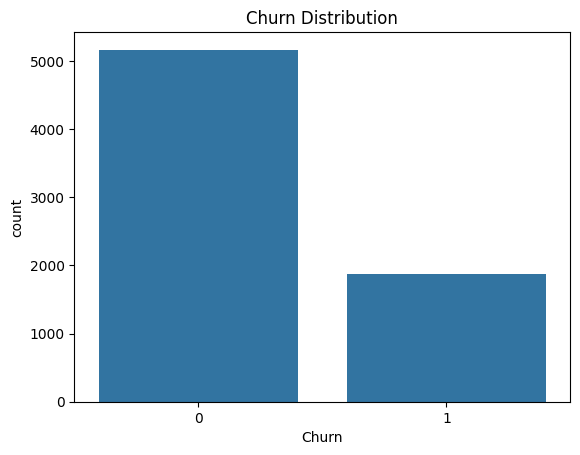

In [21]:
# Churn Distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

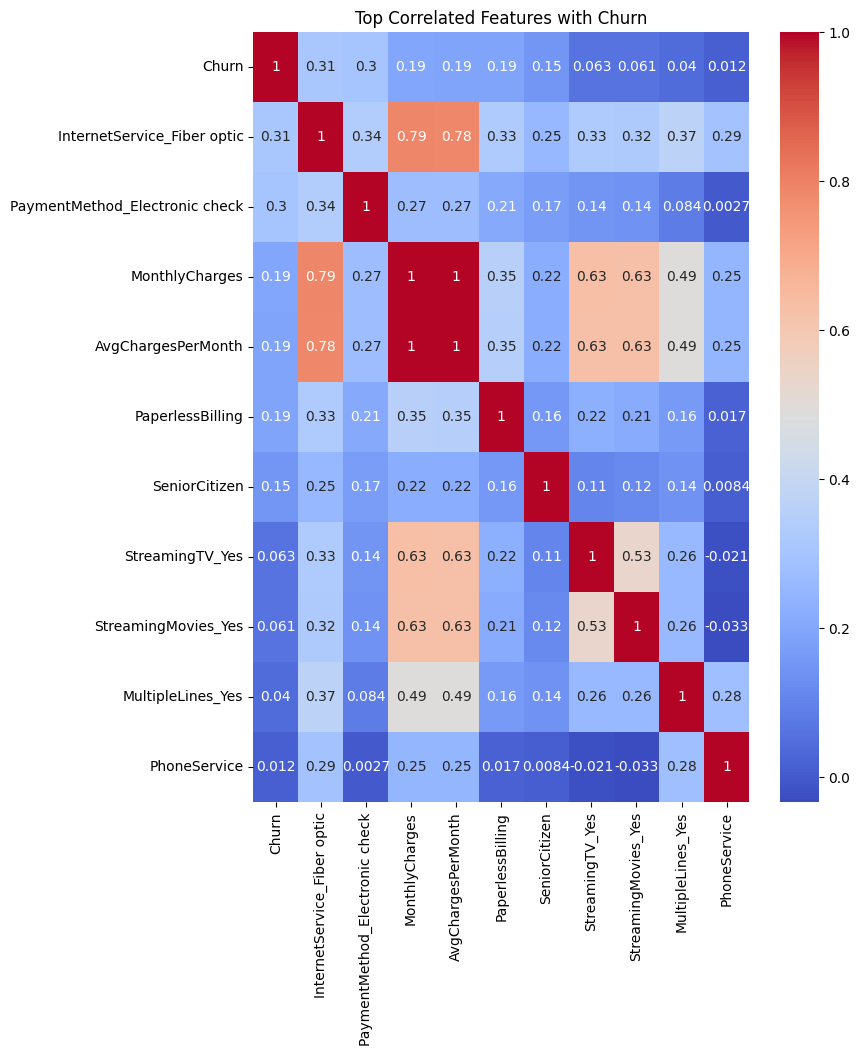

In [22]:
# Correlation with Churn (Top 10)
plt.figure(figsize=(8,10))
correlation = df.corr()["Churn"].sort_values(ascending=False)
sns.heatmap(df[correlation.index[:11]].corr(), annot=True, cmap="coolwarm")
plt.title("Top Correlated Features with Churn")
plt.show()

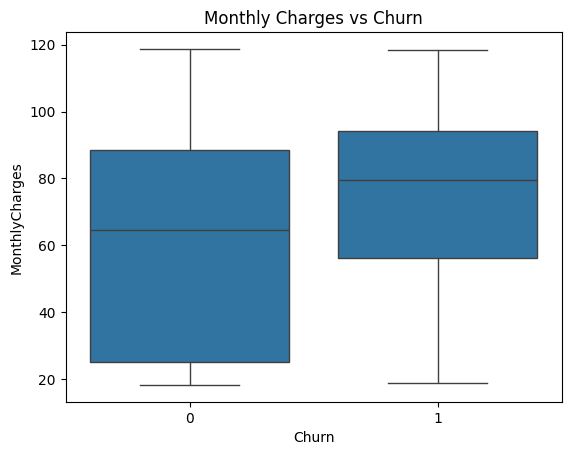

In [23]:
# Boxplots by Churn
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Monthly Charges vs Churn")
plt.show()

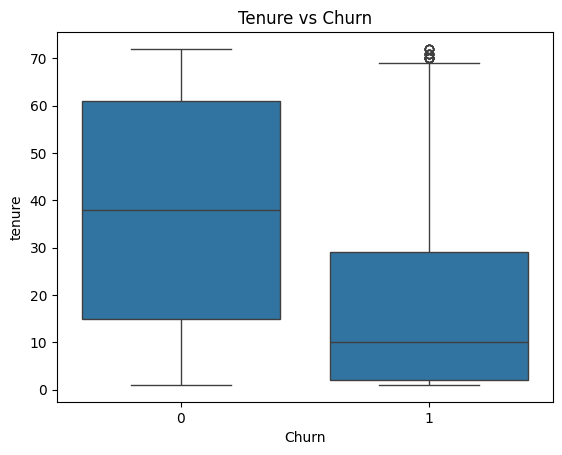

In [24]:
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("Tenure vs Churn")
plt.show()

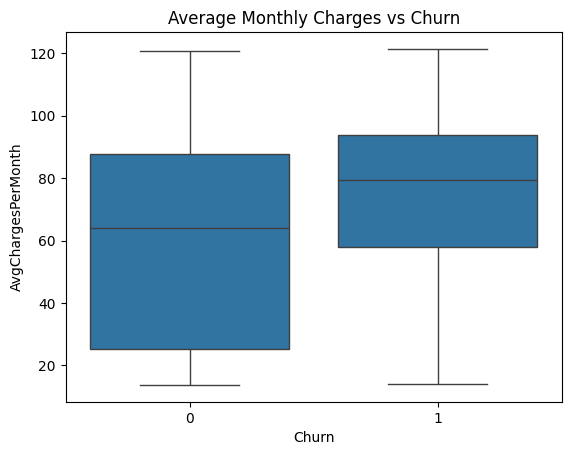

In [25]:
sns.boxplot(x="Churn", y="AvgChargesPerMonth", data=df)
plt.title("Average Monthly Charges vs Churn")
plt.show()

In [26]:
# 8. Feature Scaling (Standardization)

In [27]:
df.drop(["PhoneService", "MultipleLines_Yes", "StreamingTV_Yes", "StreamingMovies_Yes"], axis=1, inplace=True)

In [28]:
# Split into features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [29]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
# Apply SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)

In [31]:
# 9. Train/Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [33]:
# 11. Model Training & Evaluation

In [34]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Gradient Boosting": GradientBoostingClassifier()
}

In [35]:
# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc

    print(f"\n🔷 {name}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("Classification Report:\n", classification_report(y_test, preds))
    print(f"Accuracy: {acc:.4f}")

# Summary of all accuracies
print("\n Accuracy Summary:")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")


🔷 Logistic Regression
Confusion Matrix:
 [[769 268]
 [192 837]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77      1037
           1       0.76      0.81      0.78      1029

    accuracy                           0.78      2066
   macro avg       0.78      0.78      0.78      2066
weighted avg       0.78      0.78      0.78      2066

Accuracy: 0.7773

🔷 Decision Tree
Confusion Matrix:
 [[792 245]
 [245 784]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76      1037
           1       0.76      0.76      0.76      1029

    accuracy                           0.76      2066
   macro avg       0.76      0.76      0.76      2066
weighted avg       0.76      0.76      0.76      2066

Accuracy: 0.7628

🔷 Random Forest
Confusion Matrix:
 [[856 181]
 [154 875]]
Classification Report:
               precision    recall  f1-score   support

  

In [36]:
# 1. Choose the best model (XGBoost in this case)
final_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [37]:
# 2. Evaluate again (optional)
final_preds = final_model.predict(X_test)
final_acc = accuracy_score(y_test, final_preds)
print("\n Final Model (XGBoost) Evaluation")
print("Confusion Matrix:\n", confusion_matrix(y_test, final_preds))
print("Classification Report:\n", classification_report(y_test, final_preds))
print(f"Accuracy: {final_acc:.4f}")


 Final Model (XGBoost) Evaluation
Confusion Matrix:
 [[879 158]
 [155 874]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1037
           1       0.85      0.85      0.85      1029

    accuracy                           0.85      2066
   macro avg       0.85      0.85      0.85      2066
weighted avg       0.85      0.85      0.85      2066

Accuracy: 0.8485


In [38]:
# 3. Save the model
joblib.dump(final_model, "xgboost_churn_model.pkl")
print(" Model saved as xgboost_churn_model.pkl")

joblib.dump(scaler, "scaler.pkl")
print(" Scaler saved as scaler.pkl")

 Model saved as xgboost_churn_model.pkl
 Scaler saved as scaler.pkl


In [39]:
# Save the feature names
feature_names = X.columns.tolist()
joblib.dump(feature_names, "feature_names.pkl")
print("Feature names saved as feature_names.pkl")

Feature names saved as feature_names.pkl
